# mini-project: Speaker Recognition

Speaker recognition is an important tasks in many applications. The problem of speaker recognition aims at determining the speaker identity in a provided recording and matches it to a pre-recorded database or a pre-extracted speaker-related features. It can be applied in places such as secured biometric verification applications (e.g. banks) and command detection systems (e.g. smart home devices).

There are two types of tasks in the general problem of speaker recognition - **speaker identification** and **speaker verification**. Speaker identification maps a given utterance to a speaker feature, and matches it to a set of stored speaker features to identify which speaker is speaking. Speaker verification extracts the same speaker feature, but generates a *yes/no* output presenting whether the speaker is the target speaker we want to hear. We can reformulate the speaker identification problem to a one-to-many mapping problem or a multi-class classification problem (as what we did for the acoustic event detection problem), and the speaker verifcation problem to a one-to-one mapping problem or a binary classification problem.

Moreover, there are two types of problem settings in speaker recognition - **text-dependent** and **text-independent** - depending on whether we want to put any constraints on the contents. Text-dependent speaker recognition systems are designed for certain contents, such as waken words and key words in smart home devices ("Hi Siri/Cortana/Google"), while text-independent speaker recognition systems do not make any assumptions on the content. Intuitively text-independent systems are harder to work but are more general, but if you want higher recognition accuracy in certain environments, text-dependent systems are often more suitable.

In this mini-project we will implement a simplified text-independent speaker recognition system. The problem of speaker recognition is dominated by the advances of neural networks in recent years (like other tasks), so our implementation will still be on the network architectures and the training objectives. We call this the *end-to-end neural speaker recognition system*. If you are interested in the conventional methods for speaker recognition, I'll put some links at the end of this notebook.

## 1. Pipeline Description

A standard text-independent speaker recognition pipeline contains an **embedding extraction module** and an **embedding scoring module**. The embedding extraction module takes an utterance as input and generates an utterance-level embedding (speaker feature), and the embedding scoring module estimates a score (which is typically a probability or a similarity measure) by comparing the embedding from a given utterance (which is the query utterance) to the set of pre-extracted embeddings for all available speakers (a dictionary or a speaker embedding database). To calculate the speaker embedding database, the system needs a set of **enrollment** utterances from all of the speakers in order to extract the target embeddings, and the enrollments are used as the training data. Well-known systems such as [***d-vector***](https://storage.googleapis.com/pub-tools-public-publication-data/pdf/41939.pdf) and [***x-vector***](https://danielpovey.com/files/2018_icassp_xvectors.pdf) all follow this pipeline.
![](https://www.mathworks.com/matlabcentral/mlc-downloads/downloads/28aafb36-9ce9-498d-8c52-be5983e1073f/dec0d528-18a8-435b-95fc-20d2a5da0854/images/screenshot.jpg)

During the training of the end-to-end neural speaker recognition system, we have the following example procedure:
1. For each of the utterance in the enrollment data, perform a multi-class classification on the target speaker labels (as what we did for the acoustic event detection problem). The only difference is that the output from the second-last layer needs to be normalized.
2. Extract the normalized output from the second-last layer in the system (the input to the final output classification layer) as the speaker embedding feature.
3. Gather all speaker embeddings from all the enrollment utterances from a certain speaker and use them (or certain statistics of them) as the single speaker embedding for this speaker.

During the scoring of a given query utterance, we have the following example procedure:
1. Extract the speaker embedding from the query utterance.
2. For speaker identification task, compare it with all the pre-extracted speaker embeddings in the training set via certain distance measures (e.g. cosine similarity), determine the speaker identity of the query utterance by certain pre-defined similarity threshold.
3. For speaker verification task, only compare it with the target speaker's pre-extracted embedding.

## 2. Data Preparation

In this mini-project we will use a dataset sampled from Librispeech. There are 50 speakers in our data, and each speaker has 10 training utterances, 3 validation utterances and 1 test utterance. All of them are 6 second long. Similar to the previous homework and the acoustic event detection tutorial, let's prepare the data and generate the magnitude spectrogram features. The wave files are saved in the "SV_data" folder.

Note that here the speaker label for the utterances are denoted by their directory names. Take a look at the data directory arrangements before you start loading and manipulating the wave files.

In [1]:
import numpy as np
import librosa
import os
import time
import h5py
import soundfile as sf

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
from IPython.display import Audio

In [69]:
# TODO: data preparation

dir_path = 'SV_data'  # directory path
import h5py
# walk through the directory, find the files with .wav extension
tr_wav_files = []
tr_label=[]
dir_aud=dir_path+'/train'
for (dirpath, dirnames, filenames) in os.walk(dir_aud):
    for file in filenames:
        if '.wav' in file:
            tr_wav_files.append(dirpath+'/'+file)
            tr_label.append(dirpath[14:])
val_wav_files = []
val_label=[]
dir_aud=dir_path+'/validate'
for (dirpath, dirnames, filenames) in os.walk(dir_aud):
    for file in filenames:
        if '.wav' in file:
            val_wav_files.append(dirpath+'/'+file)
            val_label.append(dirpath[17:])
            
ts_wav_files = []
ts_label=[]
dir_aud=dir_path+'/test'
for (dirpath, dirnames, filenames) in os.walk(dir_aud):
    for file in filenames:
        if '.wav' in file:
            ts_wav_files.append(dirpath+'/'+file)
            ts_label.append(dirpath[13:])
            
        
num_data = len(tr_wav_files)
print('Number of .wav files: {:2d}'.format(num_data))
print('Example path: ' + tr_wav_files[0], tr_label[0])

Number of .wav files: 500
Example path: SV_data/train/spk2/utt8.wav spk2


In [83]:
tr_name = 'tr_set2.hdf5'
val_name = 'val_set2.hdf5'
test_name = 'test_set2.hdf5'

tr_dataset = h5py.File(tr_name, 'a')
val_dataset = h5py.File(val_name, 'a')
test_dataset = h5py.File(test_name, 'a')

# maximum length of waveforms 
sr = 16000  # sample rate
length_wave_max = 6 * sr

# STFT window and hop size
n_fft = 512
n_hop = n_fft // 4
tst_flag=0
trn_flag=0
val_flag=0
all_spk=['spk'+str(idd) for idd in range(1,51)]

for i in range(len(tr_wav_files)):
    
    # first 200 files for training, next 50 for validation, and last 69 for testing
    
    # load the wavefiles
    y, _ = librosa.load(tr_wav_files[i], sr=sr)  # the default sample rate for them is 16kHz, but you can also change that
    
    # truncate or zero-pad the signal
    y = y[:length_wave_max]
    if len(y) < length_wave_max:
        y = np.concatenate([y, np.zeros(length_wave_max-len(y))])
    
    # calculate log-power spectrogram in decibel scale
    spec = librosa.stft(y, n_fft=n_fft, hop_length=n_hop)
    # the 1e-8 here is added for numerical stability, in case that log10(0) happens
    log_power_spec = 10*np.log10(np.abs(spec)**2 + 1e-8)  # shape: (n_fft/2+1, T)
    num_frame = log_power_spec.shape[1]  # this should be the same for all the utterances, since we map them into same length
    
    # save them into the hdf5 file
    
    if i == 0:
        # create sub-datasets
        tr_dataset.create_dataset('waveform', shape=(len(tr_wav_files), length_wave_max), dtype=np.float32)
        tr_dataset.create_dataset('spec', shape=(len(tr_wav_files), n_fft//2+1, num_frame), dtype=np.float32)
        tr_dataset.create_dataset('label', shape=(len(tr_wav_files),), dtype=np.float32)

    tr_dataset['waveform'][i] = y
    tr_dataset['spec'][i] = log_power_spec
    tr_dataset['label'][i] =  all_spk.index(tr_label[i])
    
    
    
for i in range(len(val_wav_files)):
    
    # first 200 files for training, next 50 for validation, and last 69 for testing
    
    # load the wavefiles
    y, _ = librosa.load(val_wav_files[i], sr=sr)  # the default sample rate for them is 16kHz, but you can also change that
    
    # truncate or zero-pad the signal
    y = y[:length_wave_max]
    if len(y) < length_wave_max:
        y = np.concatenate([y, np.zeros(length_wave_max-len(y))])
    
    # calculate log-power spectrogram in decibel scale
    spec = librosa.stft(y, n_fft=n_fft, hop_length=n_hop)
    # the 1e-8 here is added for numerical stability, in case that log10(0) happens
    log_power_spec = 10*np.log10(np.abs(spec)**2 + 1e-8)  # shape: (n_fft/2+1, T)
    num_frame = log_power_spec.shape[1]  # this should be the same for all the utterances, since we map them into same length
    
    # save them into the hdf5 file
    
    if i == 0:
        # create sub-datasets
        val_dataset.create_dataset('waveform', shape=(len(val_wav_files), length_wave_max), dtype=np.float32)
        val_dataset.create_dataset('spec', shape=(len(val_wav_files), n_fft//2+1, num_frame), dtype=np.float32)
        val_dataset.create_dataset('label', shape=(len(val_wav_files),), dtype=np.float32)

    val_dataset['waveform'][i] = y
    val_dataset['spec'][i] = log_power_spec
    val_dataset['label'][i] =  all_spk.index(val_label[i])
    
    
for i in range(len(ts_wav_files)):
    
    # first 200 files for training, next 50 for validation, and last 69 for testing
    
    # load the wavefiles
    y, _ = librosa.load(ts_wav_files[i], sr=sr)  # the default sample rate for them is 16kHz, but you can also change that
    
    # truncate or zero-pad the signal
    y = y[:length_wave_max]
    if len(y) < length_wave_max:
        y = np.concatenate([y, np.zeros(length_wave_max-len(y))])
    
    # calculate log-power spectrogram in decibel scale
    spec = librosa.stft(y, n_fft=n_fft, hop_length=n_hop)
    # the 1e-8 here is added for numerical stability, in case that log10(0) happens
    log_power_spec = 10*np.log10(np.abs(spec)**2 + 1e-8)  # shape: (n_fft/2+1, T)
    num_frame = log_power_spec.shape[1]  # this should be the same for all the utterances, since we map them into same length
    
    # save them into the hdf5 file
    
    if i == 0:
        # create sub-datasets
        test_dataset.create_dataset('waveform', shape=(len(ts_wav_files), length_wave_max), dtype=np.float32)
        test_dataset.create_dataset('spec', shape=(len(ts_wav_files), n_fft//2+1, num_frame), dtype=np.float32)
        test_dataset.create_dataset('label', shape=(len(ts_wav_files),), dtype=np.float32)

    test_dataset['waveform'][i] = y
    test_dataset['spec'][i] = log_power_spec
    test_dataset['label'][i] =  all_spk.index(ts_label[i])

    
tr_dataset.close()
val_dataset.close()
test_dataset.close()

In [84]:
# load the training set
tr_dataset = h5py.File(tr_name, 'a')
tr_spec = tr_dataset['spec']  # shape: (num_data, n_fft/2+1, T)
tr_spec = np.transpose(tr_spec[:], (0, 2, 1)).reshape(-1, n_fft//2+1)  # shape: (num_data*T, n_fft/2+1)
tr_mean = np.mean(tr_spec, axis=0)  # shape: (n_fft/2+1)
tr_var = np.var(tr_spec, axis=0)  # shape: (n_fft/2+1)
tr_std = np.sqrt(tr_var + 1e-8)  # again for numerical stability

# apply normalization to all the datasets

val_dataset = h5py.File(val_name, 'a')
test_dataset = h5py.File(test_name, 'a')

tr_dataset['spec'][:] = (tr_dataset['spec'][:] - tr_mean.reshape(1,-1,1)) / tr_std.reshape(1,-1,1)
val_dataset['spec'][:] = (val_dataset['spec'][:] - tr_mean.reshape(1,-1,1)) / tr_std.reshape(1,-1,1)
test_dataset['spec'][:] = (test_dataset['spec'][:] - tr_mean.reshape(1,-1,1)) / tr_std.reshape(1,-1,1)

tr_dataset.close()
val_dataset.close()
test_dataset.close()

# save the mean and std information in files
np.save('training_mean', tr_mean)
np.save('training_std', tr_std)

In [215]:
from torch.utils.data import Dataset, DataLoader

batch_size = 8

# a class to load the saved h5py dataset
class dataset_pipeline(Dataset):
    def __init__(self, path):
        super(dataset_pipeline, self).__init__()

        self.h5pyLoader = h5py.File(path, 'r')
        
        self.spec = self.h5pyLoader['spec']
        self.label=self.h5pyLoader['label']
        
        self._len = self.spec.shape[0]  # number of utterances
    
    def __getitem__(self, index):
        spec_item = torch.from_numpy(self.spec[index].astype(np.float32))
        label_item=self.label[index].astype(np.float32)
        #label_item = torch.from_numpy([self.label[index].astype(np.float32)])
        return spec_item, label_item
    
    def __len__(self):
        return self._len
    
# define data loaders
train_loader = DataLoader(dataset_pipeline('tr_set2.hdf5'), 
                          batch_size=batch_size, 
                          shuffle=True,  # this ensures that the sequential order of the training samples will be shuffled for different training epochs
                         )

validation_loader = DataLoader(dataset_pipeline('val_set2.hdf5'), 
                               batch_size=batch_size, 
                               shuffle=False,  # typically we fix the sequential order of the validation samples
                              )
test_loader = DataLoader(dataset_pipeline('test_set2.hdf5'), 
                               batch_size=1, 
                               shuffle=False,  # typically we fix the sequential order of the validation samples
                              )
dataset_len = len(train_loader)
log_step = dataset_len // 4
print(dataset_len)

63


## 3. Network Architecture

We use the same AlexNet architecture as the one used in the acoustic event detection task. The only difference, as we mentioned above, is that the output at the second-last layer has to be normalized.

In [86]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=50):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=11, stride=4, padding=2),  # number of input channel is 1 (for image it is 3) 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(16, 32, kernel_size=5, padding=2),  # we make the number of hidden channels smaller in these layers
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((3, 3))  # perform adaptive mean pooling on any size of the input to match the provided size
        self.classifier = nn.Sequential(
            # nn.Dropout()  no Droupout layers here
            nn.Linear(64 * 3 * 3, 256),
            nn.ReLU(inplace=True),
            # nn.Dropout()  no Droupout layers here
            nn.Linear(256, 256),
            nn.Tanh() # use Tanh instead of ReLU since the output here will be used for the speaker embeddings
        )
        self.output = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)  # the dimension after adaptive average pooling is (batch, 64, 3, 3)
        x = torch.flatten(x, 1)  # average
        x = self.classifier(x)  
        # normalize before the last layer
        embedding = x / (x.pow(2).sum(1) + 1e-6).sqrt().unsqueeze(1)
        # output layer
        x = self.output(embedding)
        return x, embedding
    
# test it with a sample input
model = AlexNet()
sample_input = torch.randn(2, 1, 257, 626)  # (batch_size, num_channel, width, height)
sample_output, sample_embedding = model(sample_input)
print(sample_output.shape, sample_embedding.shape)  # (batch_size, num_classes), (batch_size, embedding_dimension)

torch.Size([2, 50]) torch.Size([2, 256])


## 4. Training and Scoring

Similarly, the training of the model is identical as what we have done for acoustic event detection. You should still report the overall accuracy with your best model on the 50 **test** utterances. You need to achieve at least 50% overall accuracy on the **validation** set to get the full mark.

In [87]:
# TODO: train the model on the dataset above

def Accuracy(prediction, label):
    """
    BCE between the predicted probabilities and the target labels.
    args:
        prediction: shape (num_frame,), torch tensor
        label: shape (num_frame,), torch tensor
    output:
        acc_value: float, a single value, a percentage value between 0 and 100 (corresponds to 0% and 100% accuracy)
    """
    batch_size = prediction.shape[0]


    acc_value= 1.0*(prediction==label)
    acc_value=acc_value.mean()*100
            
    return acc_value


In [88]:
lossF = nn.CrossEntropyLoss()
def train(model, epoch, versatile=True):
    start_time = time.time()
    model = model.train()  # set the model to training mode. Always do this before you start training!
    train_loss = 0.
    
    # load batch data
    for batch_idx, data in enumerate(train_loader):
        batch_Sp = data[0].unsqueeze(1)
        batch_label= data[1]
        
        # clean up the gradients in the optimizer
        # this should be called for each batch
        optimizer.zero_grad()
        
        output= model(batch_Sp)
        #output=torch.argmax(output,dim=1)
        
        #print('o', output[0])
        # MSE as objective
        #print('l',batch_label)
        loss = lossF(output[0], batch_label.long())
        
        # automatically calculate the backward pass
        loss.sum().backward()
        # perform the actual backpropagation
        optimizer.step()
        
        train_loss += loss.sum().data.item()
        
        # OPTIONAL: you can print the training progress 
        if versatile:
            if (batch_idx+1) % log_step == 0:
                elapsed = time.time() - start_time
                print('| epoch {:3d} | {:5d}/{:5d} batches | ms/batch {:5.2f} | BCE {:5.4f} |'.format(
                    epoch, batch_idx+1, len(train_loader),
                    elapsed * 1000 / (batch_idx+1), 
                    train_loss / (batch_idx+1)
                    ))
    
    train_loss /= (batch_idx+1)
    print('-' * 99)
    print('    | end of training epoch {:3d} | time: {:5.2f}s | BCE {:5.4f} |'.format(
            epoch, (time.time() - start_time), train_loss))
    
    return train_loss
        
def validate(model, epoch):
    start_time = time.time()
    model = model.eval()  # set the model to evaluation mode. Always do this during validation or test phase!
    validation_loss = 0.
    
    # load batch data
    for batch_idx, data in enumerate(validation_loader):
        batch_Sp = data[0].unsqueeze(1)
        batch_label= data[1]
        
        # you don't need to calculate the backward pass and the gradients during validation
        # so you can call torch.no_grad() to only calculate the forward pass to save time and memory
        with torch.no_grad():
        
            output= model(batch_Sp)
            output=torch.argmax(output[0],dim=1)

            #print('o', output.shape)
            # MSE as objective
            #print('l',batch_label.shape)
            loss = Accuracy(output, batch_label.long())
        
            validation_loss += loss.data.item()
    
    validation_loss /= (batch_idx+1)
    print('    | end of validation epoch {:3d} | time: {:5.2f}s | accs {:5.4f} |'.format(
            epoch, (time.time() - start_time), validation_loss))
    print('-' * 99)
    
    return validation_loss


In [90]:
total_epoch = 60  # train the model for 100 epochs
model_save = 'best_model_SV.pt'  # path to save the best validation model

# main function

training_loss = []
validation_loss = []

model_AN = AlexNet()
optimizer = optim.Adam(model_AN.parameters(), lr=1e-4)
for epoch in range(1, total_epoch + 1):
    training_loss.append(train(model_AN , epoch))
    validation_loss.append(validate(model_AN, epoch))
    if training_loss[-1] == np.min(training_loss):
        print('      Best training model found.')
    if validation_loss[-1] == np.max(validation_loss):
        # save current best model on validation set
        with open(model_save, 'wb') as f:
            torch.save(model_AN.state_dict(), f)
            print('      Best validation model found and saved.')
    
    print('-' * 99)

| epoch   1 |    15/   63 batches | ms/batch 176.06 | BCE 3.9167 |
| epoch   1 |    30/   63 batches | ms/batch 174.15 | BCE 3.9134 |
| epoch   1 |    45/   63 batches | ms/batch 173.48 | BCE 3.9147 |
| epoch   1 |    60/   63 batches | ms/batch 173.16 | BCE 3.9156 |
---------------------------------------------------------------------------------------------------
    | end of training epoch   1 | time: 10.83s | BCE 3.9161 |
    | end of validation epoch   1 | time:  0.81s | accs 2.6316 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
| epoch   2 |    15/   63 batches | ms/batch 173.82 | BCE 3.9112 |
| epoch   2 |    30/   63 batches | ms/batch 173.50 | BCE 3.9081 |
| epoch   2 |    45/   63 batches | ms/batch 173.29 | BCE 3.9059 |
| epoch   2 |    60/   63 

| epoch  12 |    15/   63 batches | ms/batch 182.23 | BCE 3.5790 |
| epoch  12 |    30/   63 batches | ms/batch 178.59 | BCE 3.5720 |
| epoch  12 |    45/   63 batches | ms/batch 178.49 | BCE 3.5719 |
| epoch  12 |    60/   63 batches | ms/batch 178.27 | BCE 3.5681 |
---------------------------------------------------------------------------------------------------
    | end of training epoch  12 | time: 11.16s | BCE 3.5665 |
    | end of validation epoch  12 | time:  0.80s | accs 28.9474 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
| epoch  13 |    15/   63 batches | ms/batch 177.11 | BCE 3.5500 |
| epoch  13 |    30/   63 batches | ms/batch 177.07 | BCE 3.5450 |
| epoch  13 |    45/   63 batches | ms/batch 178.84 | BCE 3.5375 |
| epoch  13 |    60/   63

| epoch  23 |    15/   63 batches | ms/batch 181.07 | BCE 3.2837 |
| epoch  23 |    30/   63 batches | ms/batch 178.92 | BCE 3.2844 |
| epoch  23 |    45/   63 batches | ms/batch 182.27 | BCE 3.2731 |
| epoch  23 |    60/   63 batches | ms/batch 185.04 | BCE 3.2721 |
---------------------------------------------------------------------------------------------------
    | end of training epoch  23 | time: 11.57s | BCE 3.2698 |
    | end of validation epoch  23 | time:  0.87s | accs 48.6842 |
---------------------------------------------------------------------------------------------------
      Best training model found.
---------------------------------------------------------------------------------------------------
| epoch  24 |    15/   63 batches | ms/batch 191.02 | BCE 3.2487 |
| epoch  24 |    30/   63 batches | ms/batch 191.90 | BCE 3.2414 |
| epoch  24 |    45/   63 batches | ms/batch 192.85 | BCE 3.2414 |
| epoch  24 |    60/   63 batches | ms/batch 191.70 | BCE 3.2449 |
---

| epoch  34 |    15/   63 batches | ms/batch 183.57 | BCE 2.9666 |
| epoch  34 |    30/   63 batches | ms/batch 183.15 | BCE 2.9685 |
| epoch  34 |    45/   63 batches | ms/batch 183.02 | BCE 2.9662 |
| epoch  34 |    60/   63 batches | ms/batch 183.28 | BCE 2.9661 |
---------------------------------------------------------------------------------------------------
    | end of training epoch  34 | time: 11.45s | BCE 2.9674 |
    | end of validation epoch  34 | time:  0.81s | accs 66.8860 |
---------------------------------------------------------------------------------------------------
      Best training model found.
---------------------------------------------------------------------------------------------------
| epoch  35 |    15/   63 batches | ms/batch 174.75 | BCE 2.9604 |
| epoch  35 |    30/   63 batches | ms/batch 179.01 | BCE 2.9516 |
| epoch  35 |    45/   63 batches | ms/batch 181.51 | BCE 2.9490 |
| epoch  35 |    60/   63 batches | ms/batch 182.46 | BCE 2.9392 |
---

| epoch  45 |    15/   63 batches | ms/batch 176.61 | BCE 2.6637 |
| epoch  45 |    30/   63 batches | ms/batch 176.75 | BCE 2.6516 |
| epoch  45 |    45/   63 batches | ms/batch 176.37 | BCE 2.6474 |
| epoch  45 |    60/   63 batches | ms/batch 176.36 | BCE 2.6561 |
---------------------------------------------------------------------------------------------------
    | end of training epoch  45 | time: 11.03s | BCE 2.6566 |
    | end of validation epoch  45 | time:  0.80s | accs 81.1404 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
| epoch  46 |    15/   63 batches | ms/batch 181.86 | BCE 2.6239 |
| epoch  46 |    30/   63 batches | ms/batch 179.75 | BCE 2.6274 |
| epoch  46 |    45/   63 batches | ms/batch 182.31 | BCE 2.6220 |
| epoch  46 |    60/   63

| epoch  56 |    15/   63 batches | ms/batch 182.00 | BCE 2.3450 |
| epoch  56 |    30/   63 batches | ms/batch 188.05 | BCE 2.3530 |
| epoch  56 |    45/   63 batches | ms/batch 189.56 | BCE 2.3519 |
| epoch  56 |    60/   63 batches | ms/batch 188.59 | BCE 2.3521 |
---------------------------------------------------------------------------------------------------
    | end of training epoch  56 | time: 11.79s | BCE 2.3505 |
    | end of validation epoch  56 | time:  0.86s | accs 83.1140 |
---------------------------------------------------------------------------------------------------
      Best training model found.
---------------------------------------------------------------------------------------------------
| epoch  57 |    15/   63 batches | ms/batch 184.54 | BCE 2.3384 |
| epoch  57 |    30/   63 batches | ms/batch 183.39 | BCE 2.3323 |
| epoch  57 |    45/   63 batches | ms/batch 184.38 | BCE 2.3275 |
| epoch  57 |    60/   63 batches | ms/batch 184.81 | BCE 2.3222 |
---

In [95]:
# TODO: evaluate your best model on the test set




model_SV=AlexNet()
model_SV.load_state_dict(torch.load('best_model_SV.pt'))
test_loss=0
for batch_idx, data in enumerate(test_loader):
    
    batch_Sp = data[0].unsqueeze(1)
    batch_label= data[1]
        
        # you don't need to calculate the backward pass and the gradients during validation
        # so you can call torch.no_grad() to only calculate the forward pass to save time and memory
    with torch.no_grad():

        output= model_SV(batch_Sp)
        output=torch.argmax(output[0],dim=1)

        #print('o', output.shape)
        # MSE as objective
        #print('l',batch_label.shape)
        loss = Accuracy(output, batch_label.long())

        test_loss += loss.data.item()
    
test_loss /= (batch_idx+1)
print('    | end of test |  test_accs: ', test_loss)

    | end of test |  test_accs:  86.0


In the acoustic event detection task, the estimated target class can be directly used as what we want is indeed the class label. However, in speaker recognition task we have another step - **scoring**. This stage is useful here because in many cases the query speaker might not match any of the saved speakers, and we might not be able to assign a proper speaker label to it. In speaker identification task, this means that we cannot always perform *argmax* on the network output to assign the corresponding speaker label to it. In speaker verification task, this means that we can only say the query speaker matches the target speaker when the similarity score is higher than a (predefined) threshold. Acoustic event detection task often assumes that all the possible types of audio events are known and there won't be out-of-box event types, and there is also no need to perform such verification process for such scenes.

One of the most simple way to perform scoring is to compare the speaker embedding from the query utterance to the overall characteristics from the training set. The overall characteristics for a target speaker is generated by averaging across all the speaker embeddings of the speaker's training utterances. You can intuitively treat it as a clustering process, and the average embedding is essentially the cluster center for all the possible speaker embeddings for one speaker.

Extract all the training speaker embeddings below and calculate the average speaker embeddings.

In [126]:
# TODO: extract speaker embeddings for each of the speaker's training utterance
# use the best model on validation set above
# save all training speaker embeddings as all_embedding (shape: (500, 256) for (num_spk*num_utterance, embedding_dim))
# save average speaker embeddings as average_embedding (shape: (50, 256) for (num_spk, embedding_dim))
# remember to convert them to numpy.array format!

flag_all_embedding=0

for batch_idx, data in enumerate(train_loader):
    
    batch_Sp = data[0].unsqueeze(1)
    batch_label= data[1]
        
        # you don't need to calculate the backward pass and the gradients during validation
        # so you can call torch.no_grad() to only calculate the forward pass to save time and memory
    with torch.no_grad():
        output= model_SV(batch_Sp)
        embed=output[1]
        if flag_all_embedding==0:
            flag_all_embedding=1
            all_embedding=embed
            all_L=batch_label
        else:
            all_embedding=torch.cat((all_embedding,embed),0)
            all_L=torch.cat((all_L,batch_label))
            
        #output=torch.argmax(output[0],dim=1)

        #print('o', output.shape)
        # MSE as objective
        #print('l',batch_label.shape)
        #loss = Accuracy(output, batch_label.long())

        #test_loss += loss.data.item()
print(all_embedding.size(), all_L.size())
all_embedding=all_embedding.cpu().detach().numpy()
all_L=all_L.cpu().detach().numpy()

average_embedding=np.zeros((50,np.shape(all_embedding)[1]))
for i in range(50):
    average_embedding[i,:]=np.mean(all_embedding[all_L.astype('int')==i,:],axis=0)
all_embedding=np.array(all_embedding)
average_embedding=np.array(average_embedding)

torch.Size([500, 256]) torch.Size([500])


In [133]:
print(all_L.shape)

(500,)


Let's visualize the embeddings. Note that the embeddings are pretty high-dimensional (256-dimensional) and it is impossible to directly visualize them. We need certain **dimension reduction** methods to map them to a low-dimensional space (2 or 3-dimensional space) for us to learn about their properties. The most simply way to perform dimension reduction is **principal component analysis (PCA)**, and let's use the [*sklearn.decomposition.PCA*](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) to do it.

Apply the PCA function to the ***all_embedding*** matrix, set the number of reduced dimension to 2 (*n_components=2*), and visualize the embeddings for the first 5 speakers (first 50 embeddings in *all_embedding*) by plotting a scatter plot. Use different colors for different speakers.

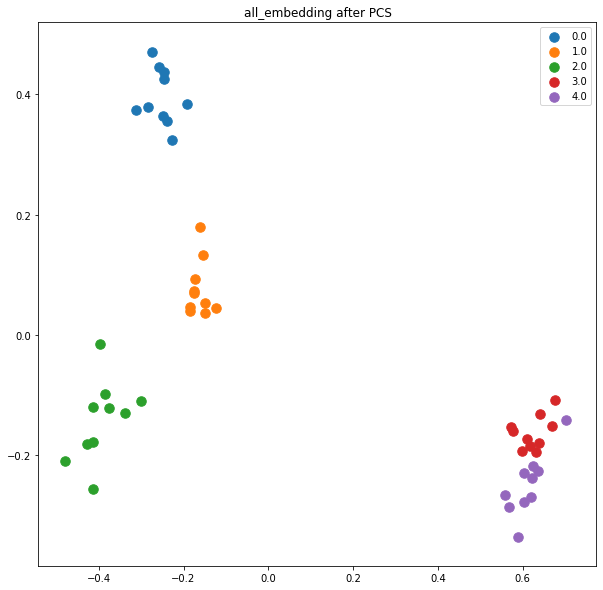

In [141]:
# TODO: perform PCA on the embeddings, visualize the embeddings for the first 5 speakers
from sklearn.decomposition import PCA
import pandas as pd
pca = PCA(n_components=2)
pca.fit(all_embedding)

y=pca.transform(all_embedding)


data = pd.DataFrame({"X Value": y[:, 0], "Y Value":y[:, 1], "Category": all_L})
groups = data.groupby("Category")
plt.figure(figsize=(10,10))
for name, group in groups:
    if name<5:


        plt.scatter(group["X Value"], group["Y Value"], s=90, label=name)
plt.legend()

plt.title( 'all_embedding after PCS')
    


plt.show()






You should see that embeddings for different speakers are separate apart and each speaker has a cluster. For a query speaker utterance, we can compute its score with respect to all the speakers in the training utterances by calculating a similarity measure between the speaker embedding for this query utterance and all the average speaker embeddings. One of such similarity measure is **cosine similarity**, and let's apply it on our test set.

In [181]:
# TODO: calculate the cosine similarity scores between each utterance in the test set and all the average embeddings
# save your cosine similarity scores in cos_sim (shape: (50, 50) for (num_target_spk, num_test_utterance))

from scipy import spatial
cos_sim=np.zeros((50,50))
ts_L=np.zeros(50)
for batch_idx, data in enumerate(test_loader):
    
    batch_Sp = data[0].unsqueeze(1)
    batch_label= data[1]
        # you don't need to calculate the backward pass and the gradients during validation
        # so you can call torch.no_grad() to only calculate the forward pass to save time and memory
    ts_L[batch_idx]=batch_label.cpu().detach().numpy()
    with torch.no_grad():
        output= model_SV(batch_Sp)
        embed=output[1]
        for i in range(50):
            result = 1 - spatial.distance.cosine(embed.cpu().detach().numpy(),average_embedding[i,:] )
            cos_sim[i,batch_idx]=result
order=[np.where(idd==ts_L.astype('int'))[0][0] for idd in range(50)]
cos_sim=cos_sim[:,order]            

In [182]:
print(order)

[30, 0, 6, 5, 1, 29, 34, 28, 35, 17, 14, 41, 47, 46, 42, 13, 19, 9, 21, 11, 20, 49, 39, 40, 48, 22, 10, 18, 12, 32, 26, 4, 7, 8, 3, 27, 31, 25, 33, 45, 36, 16, 23, 24, 15, 37, 44, 38, 43, 2]


Now you have a 50*50 matrix of all the cosine similarity scores. Let's visualize it as a confusion matrix.

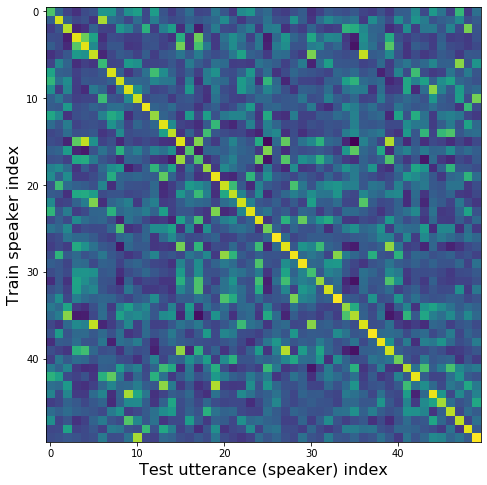

In [183]:
# visualize the cosine similarity scores as a confusion matrix

# this is the most simple way to plot it
plt.figure(figsize=(8,8))
plt.imshow(cos_sim)
plt.xlabel('Test utterance (speaker) index', fontsize=16)
plt.ylabel('Train speaker index', fontsize=16)
plt.show()

You may observe that for a successfull speaker recognition, the elements on the diagonal typically present the highest score for each test utterance. This is indeed what we expect.

Now we need a way to properly evaluate our system. We had the classification accuracy above which can be used for the identification task where we assume that we know all the target speakers to be identified in advance. For verification task which is indeed a binary classification task (accept/reject), we need other ways to determine the threshold for the similarity scores as well as measure the system's performance. One widely-used metric for evaluation in the verification task is the ***equal error rate (EER)***, defined as a value when [Type I = Type II error](https://en.wikipedia.org/wiki/Type_I_and_type_II_errors). It can be derived from the [***receiver operating characteristic (ROC) curve***](https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics). I will not go into the details here and you can refer to the links for further information as well as its usage. A sample implementation of EER is directly provided here.

In [184]:
# EER calculation with ROC curve
# adopted from https://yangcha.github.io/EER-ROC/

from scipy.optimize import brentq
from scipy.interpolate import interp1d
from sklearn.metrics import roc_curve

def EER(y, y_pred):
    # y_pred is a list of similarity scores for the verification task (cosine similarity values)
    # y is a list of the binary labels (accept/reject), where 1 is used for acceptance
    fpr, tpr, threshold = roc_curve(y, y_pred, pos_label=1)
    
    eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
    decision_threshold = interp1d(fpr, threshold)(eer)
    
    return eer, decision_threshold

# example usage on the test utterances
# verify if each test utterance matches each of the target speakers
# a total of 50*50=2500 verification tasks

label = np.diag(np.ones(50)).reshape(-1).astype(np.float32)
eer, decision_threshold = EER(label, cos_sim.reshape(-1))
print('Overall EER: {:.2f}%; decision threshold for similarity scores: {:.2f}'.format(eer*100, decision_threshold))

Overall EER: 2.94%; decision threshold for similarity scores: 0.52


## 5. Siamese Network and Triplet Loss

What we have implemented above is an example pipeline - we train a standard multiclass classification system, use the feature as speaker embeddings, and identify (classify) or verify (score) them for the two tasks. However, there are other ways that we can train the model. Here we introduce another pipeline called ***siamese network and triplet loss***.

Let's first take a look at this illustration (https://levelup.gitconnected.com/metric-learning-using-siamese-and-triplet-convolutional-neural-networks-ed5b01d83be3).

![](https://miro.medium.com/max/1400/1*MIPdyhJGx6uLiob9UI9S0w.png)

We have three input images in this illustration. The term ***siamese network*** corresponds to the design that all three input images share the same network (same architecture and same parameters), and the term ***triplet loss*** corresponds to the training objective function applied to the three inputs. The three inputs, $x_a$, $x_p$ and $x_n$, represent the ***a*nchor input**, ***p*ositive sample**, and the ***n*egative sample**, respectively. In our case of speaker recognition, the anchor input is an utterance from a random speaker A, the positive sample is another utterance from the same speaker A, and the negative sample is an utterance from a random speaker B different from A. 

The triplet loss tries to **maximize** the similarity between the anchor input and the positive sample, and to **minimize** the similarity between the anchor input and the negative sample. The $\alpha$ term is a predefined nonnegative scalar determining the minimum margin of the difference between the two similarity scores. In our case of speaker recognition where cosine similarity is used for the similarity score, it is equivalent to the following objective:
$$\theta_{a,p} > \theta_{a,n} + \alpha$$
where $\theta$ corresponds to the cosine similarity. The triplet loss can then be written as:
$$L_{triplet} = max(\theta_{a,n} - \theta_{a,p} + \alpha , 0)$$

When $\theta_{a,p} > \theta_{a,n} + \alpha$, $max(\theta_{a,n} - \theta_{a,p} + \alpha , 0) = 0$ and there's no gradient with respect to the cosine similarity scores. This means that the negative and positive samples are already separated enough and no further optimization is required. When $\theta_{a,p} \leq \theta_{a,n} + \alpha$, $max(\theta_{a,n} - \theta_{a,p} + \alpha , 0) = \theta_{a,n} - \theta_{a,p} + \alpha$, and gradient descent on $L_{triplet}$ will minimize $\theta_{a,n}$ and maximize $\theta_{a,p}$. Given that the range of the cosine similarity scores are [-1, 1], let's empirically set $\alpha=1$ in our experiment.

Note that the difference between our loss and the loss in the illustration comes from the use of the **distance measure** $d(\cdot)$ instead of a **similarity measure** in the illustration. If we use a distance measure here (e.g. Euclidean distance), then the loss needs to be modified accordingly.

Now let's implement this triplet loss and add it to the original cross entropy loss. You need to write a new data loading function as we need one random positive sample and one negative sample for each of the anchor input in the training set. You can do something like:
- Sample another batch of data for the triplet loss:
    - Sample two speaker indices (e.g. speaker 2 and speaker 6).
    - Sample two utterances from the first speaker (e.g speaker 2) to form the anchor input and the positive sample, and sample one utterance from the second speaker (speaker 6) to form the negative sample.
    - Generate the speaker embeddings for the selected utterances, calculate cosine similarity and the triplet loss.

Note that the validation stage also makes use of the randomly sampled utterances for triplet loss. If you want to use a fixed set of triplet input samples, you can predefine a set of speaker and utterance indices shared by all epochs.

In [223]:
# TODO: train another network with triplet loss
from torch.utils.data import Dataset, DataLoader

batch_size = 8
def findTrip(a,b,c,idx):
    if a==b and a!=c:
        pos=idx[0]
        ref=idx[1]
        neg=idx[2]
    elif a==c and a!=b:
        pos=idx[0]
        ref=idx[2]
        neg=idx[1]
    elif b==c and b!=a:
        pos=idx[1]
        ref=idx[2]
        neg=idx[0]
    else:
        pos=0
        ref=0
        neg=0
    return ref,pos,neg

# a class to load the saved h5py dataset
class dataset_pipeline(Dataset):
    def __init__(self, path):
        super(dataset_pipeline, self).__init__()

        self.h5pyLoader = h5py.File(path, 'r')
        
        self.spec = self.h5pyLoader['spec']
        self.label=self.h5pyLoader['label']
        
        self.ITR= list(itertools.combinations(range(self.spec.shape[0]), 3))
        self._len = len(self.ITR)  # number of utterances
    def __getitem__(self, index):
        a,b,c=self.ITR[index]
        L1,L2,L3=self.label[a],self.label[b],self.label[c]
        ref,pos,neg=findTrip(L1.astype('int'),L2.astype('int'),L3.astype('int'), (a,b,c))
        spec_item_r, label_item_r, spec_item_p, label_item_p, spec_item_n, label_item_n=[],[],[],[],[],[]
        if ref or pos or neg:
            spec_item_r = torch.from_numpy(self.spec[ref].astype(np.float32))
            label_item_r=self.label[ref].astype(np.float32)
            spec_item_p = torch.from_numpy(self.spec[pos].astype(np.float32))
            label_item_p=self.label[pos].astype(np.float32)
            spec_item_n = torch.from_numpy(self.spec[neg].astype(np.float32))
            label_item_n=self.label[neg].astype(np.float32)
        #label_item = torch.from_numpy([self.label[index].astype(np.float32)])
        return spec_item_r, label_item_r, spec_item_p, label_item_p, spec_item_n, label_item_n
    
    def __len__(self):
        return self._len
    
# define data loaders
train_loader2 = DataLoader(dataset_pipeline('tr_set2.hdf5'), 
                          batch_size=1, 
                          shuffle=True,  # this ensures that the sequential order of the training samples will be shuffled for different training epochs
                         )

validation_loader2 = DataLoader(dataset_pipeline('val_set2.hdf5'), 
                               batch_size=1, 
                               shuffle=False,  # typically we fix the sequential order of the validation samples
                              )
test_loader2 = DataLoader(dataset_pipeline('test_set2.hdf5'), 
                               batch_size=1, 
                               shuffle=False,  # typically we fix the sequential order of the validation samples
                              )
dataset_len = len(train_loader)
log_step = dataset_len // 4
print(dataset_len)





63


In [224]:
lossF = nn.CrossEntropyLoss()
cos = nn.CosineSimilarity(dim=1, eps=1e-6)
def train(model, epoch, versatile=True):
    start_time = time.time()
    model = model.train()  # set the model to training mode. Always do this before you start training!
    train_loss = 0.
    
    # load batch data
    for batch_idx, data in enumerate(train_loader2):
        if len(data[0])>0:
            batch_Sp_r = data[0].unsqueeze(1)
            batch_label_r= data[1]
            batch_Sp_p = data[2].unsqueeze(1)
            batch_label_p= data[3]
            batch_Sp_n = data[4].unsqueeze(1)
            batch_label_n= data[5]
            # clean up the gradients in the optimizer
            # this should be called for each batch
            optimizer.zero_grad()

            output_r= model(batch_Sp_r)
            output_p= model(batch_Sp_p)
            output_n= model(batch_Sp_n)

            dp=1-cos(output_p[1],output_r[1] )
            dn=1-cos(output_n[1],output_r[1] )

            #output=torch.argmax(output,dim=1)

            #print('o', output[0])
            # MSE as objective
            #print('l',batch_label)
            loss = nn.functional.relu(dp-dn+1)

            # automatically calculate the backward pass
            loss.sum().backward()
            # perform the actual backpropagation
            optimizer.step()

            train_loss += loss.sum().data.item()

            # OPTIONAL: you can print the training progress 
            if versatile:
                if (batch_idx+1) % log_step == 0:
                    elapsed = time.time() - start_time
                    print('| epoch {:3d} | {:5d}/{:5d} batches | ms/batch {:5.2f} | BCE {:5.4f} |'.format(
                        epoch, batch_idx+1, len(train_loader),
                        elapsed * 1000 / (batch_idx+1), 
                        train_loss / (batch_idx+1)
                        ))

            train_loss /= (batch_idx+1)
            print('-' * 99)
            print('    | end of training epoch {:3d} | time: {:5.2f}s | BCE {:5.4f} |'.format(
                    epoch, (time.time() - start_time), train_loss))
    
    return train_loss
        
def validate(model, epoch):
    start_time = time.time()
    model = model.eval()  # set the model to evaluation mode. Always do this during validation or test phase!
    validation_loss = 0.
    
    # load batch data
    for batch_idx, data in enumerate(validation_loader2):
        if len(data[0])>0:
            batch_Sp_r = data[0].unsqueeze(1)
            batch_label_r= data[1]
            batch_Sp_p = data[2].unsqueeze(1)
            batch_label_p= data[3]
            batch_Sp_n = data[4].unsqueeze(1)
            batch_label_n= data[5]
            # clean up the gradients in the optimizer
            # this should be called for each batch
            optimizer.zero_grad()

            output_r= model(batch_Sp_r)
            output_p= model(batch_Sp_p)
            output_n= model(batch_Sp_n)

            dp=1-cos(output_p[1],output_r[1])
            dn=1-cos(output_n[1],output_r[1] )

            #output=torch.argmax(output,dim=1)

            #print('o', output[0])
            # MSE as objective
            #print('l',batch_label)
            loss = nn.functional.relu(dp-dn+1)
        
            validation_loss += loss.data.item()
    
            validation_loss /= (batch_idx+1)
            print('    | end of validation epoch {:3d} | time: {:5.2f}s | accs {:5.4f} |'.format(
                    epoch, (time.time() - start_time), validation_loss))
            print('-' * 99)
    
    return validation_loss


In [225]:
total_epoch = 60  # train the model for 100 epochs
model_save = 'best_model_SV3.pt'  # path to save the best validation model

# main function

training_loss = []
validation_loss = []

model_AN3 = AlexNet()
optimizer = optim.Adam(model_AN3.parameters(), lr=1e-4)
for epoch in range(1, total_epoch + 1):
    training_loss.append(train(model_AN3 , epoch))
    validation_loss.append(validate(model_AN3, epoch))
    if training_loss[-1] == np.min(training_loss):
        print('      Best training model found.')
    if validation_loss[-1] == np.max(validation_loss):
        # save current best model on validation set
        with open(model_save, 'wb') as f:
            torch.save(model_AN3.state_dict(), f)
            print('      Best validation model found and saved.')
    
    print('-' * 99)

---------------------------------------------------------------------------------------------------
    | end of training epoch   1 | time:  1.69s | BCE 0.0278 |
---------------------------------------------------------------------------------------------------
    | end of training epoch   1 | time:  1.77s | BCE 0.0223 |
---------------------------------------------------------------------------------------------------
    | end of training epoch   1 | time:  1.87s | BCE 0.0112 |
---------------------------------------------------------------------------------------------------
    | end of training epoch   1 | time:  1.97s | BCE 0.0089 |
---------------------------------------------------------------------------------------------------
    | end of training epoch   1 | time:  2.05s | BCE 0.0085 |
---------------------------------------------------------------------------------------------------
    | end of training epoch   1 | time:  2.14s | BCE 0.0079 |
----------------------------

---------------------------------------------------------------------------------------------------
    | end of training epoch   1 | time:  6.50s | BCE 0.0011 |
---------------------------------------------------------------------------------------------------
    | end of training epoch   1 | time:  6.60s | BCE 0.0010 |
---------------------------------------------------------------------------------------------------
    | end of training epoch   1 | time:  6.69s | BCE 0.0009 |
---------------------------------------------------------------------------------------------------
    | end of training epoch   1 | time:  6.78s | BCE 0.0009 |
---------------------------------------------------------------------------------------------------
    | end of training epoch   1 | time:  6.89s | BCE 0.0008 |
---------------------------------------------------------------------------------------------------
    | end of training epoch   1 | time:  6.97s | BCE 0.0010 |
----------------------------

| epoch   1 |  2205/   63 batches | ms/batch  5.21 | BCE 0.0004 |
---------------------------------------------------------------------------------------------------
    | end of training epoch   1 | time: 11.48s | BCE 0.0004 |
---------------------------------------------------------------------------------------------------
    | end of training epoch   1 | time: 11.56s | BCE 0.0005 |
---------------------------------------------------------------------------------------------------
    | end of training epoch   1 | time: 11.65s | BCE 0.0004 |
---------------------------------------------------------------------------------------------------
    | end of training epoch   1 | time: 11.74s | BCE 0.0004 |
---------------------------------------------------------------------------------------------------
    | end of training epoch   1 | time: 11.84s | BCE 0.0004 |
---------------------------------------------------------------------------------------------------
    | end of training ep

---------------------------------------------------------------------------------------------------
    | end of training epoch   1 | time: 16.16s | BCE 0.0000 |
---------------------------------------------------------------------------------------------------
    | end of training epoch   1 | time: 16.24s | BCE 0.0003 |
| epoch   1 |  2880/   63 batches | ms/batch  5.67 | BCE 0.0002 |
---------------------------------------------------------------------------------------------------
    | end of training epoch   1 | time: 16.34s | BCE 0.0002 |
---------------------------------------------------------------------------------------------------
    | end of training epoch   1 | time: 16.46s | BCE 0.0000 |
---------------------------------------------------------------------------------------------------
    | end of training epoch   1 | time: 16.56s | BCE 0.0003 |
---------------------------------------------------------------------------------------------------
    | end of training ep

---------------------------------------------------------------------------------------------------
    | end of training epoch   1 | time: 21.30s | BCE 0.0002 |
---------------------------------------------------------------------------------------------------
    | end of training epoch   1 | time: 21.41s | BCE 0.0002 |
---------------------------------------------------------------------------------------------------
    | end of training epoch   1 | time: 21.50s | BCE 0.0003 |
---------------------------------------------------------------------------------------------------
    | end of training epoch   1 | time: 21.61s | BCE 0.0002 |
---------------------------------------------------------------------------------------------------
    | end of training epoch   1 | time: 21.70s | BCE 0.0000 |
---------------------------------------------------------------------------------------------------
    | end of training epoch   1 | time: 21.79s | BCE 0.0000 |
----------------------------

---------------------------------------------------------------------------------------------------
    | end of training epoch   1 | time: 26.22s | BCE 0.0002 |
---------------------------------------------------------------------------------------------------
    | end of training epoch   1 | time: 26.31s | BCE 0.0002 |
---------------------------------------------------------------------------------------------------
    | end of training epoch   1 | time: 26.41s | BCE 0.0004 |
---------------------------------------------------------------------------------------------------
    | end of training epoch   1 | time: 26.51s | BCE 0.0002 |
---------------------------------------------------------------------------------------------------
    | end of training epoch   1 | time: 26.63s | BCE 0.0002 |
| epoch   1 |  4845/   63 batches | ms/batch  5.52 | BCE 0.0002 |
---------------------------------------------------------------------------------------------------
    | end of training ep

---------------------------------------------------------------------------------------------------
    | end of training epoch   1 | time: 31.13s | BCE 0.0000 |
---------------------------------------------------------------------------------------------------
    | end of training epoch   1 | time: 31.25s | BCE 0.0000 |
---------------------------------------------------------------------------------------------------
    | end of training epoch   1 | time: 31.35s | BCE 0.0001 |
---------------------------------------------------------------------------------------------------
    | end of training epoch   1 | time: 31.45s | BCE 0.0001 |
---------------------------------------------------------------------------------------------------
    | end of training epoch   1 | time: 31.54s | BCE 0.0003 |
| epoch   1 |  5595/   63 batches | ms/batch  5.66 | BCE 0.0000 |
---------------------------------------------------------------------------------------------------
    | end of training ep

---------------------------------------------------------------------------------------------------
    | end of training epoch   1 | time: 36.00s | BCE 0.0001 |
---------------------------------------------------------------------------------------------------
    | end of training epoch   1 | time: 36.10s | BCE 0.0001 |
---------------------------------------------------------------------------------------------------
    | end of training epoch   1 | time: 36.20s | BCE 0.0001 |
---------------------------------------------------------------------------------------------------
    | end of training epoch   1 | time: 36.29s | BCE 0.0000 |
---------------------------------------------------------------------------------------------------
    | end of training epoch   1 | time: 36.38s | BCE 0.0002 |
---------------------------------------------------------------------------------------------------
    | end of training epoch   1 | time: 36.47s | BCE 0.0000 |
----------------------------

---------------------------------------------------------------------------------------------------
    | end of training epoch   1 | time: 40.66s | BCE 0.0001 |
---------------------------------------------------------------------------------------------------
    | end of training epoch   1 | time: 40.75s | BCE 0.0000 |
---------------------------------------------------------------------------------------------------
    | end of training epoch   1 | time: 40.83s | BCE 0.0000 |
---------------------------------------------------------------------------------------------------
    | end of training epoch   1 | time: 40.92s | BCE 0.0001 |
---------------------------------------------------------------------------------------------------
    | end of training epoch   1 | time: 41.00s | BCE 0.0000 |
---------------------------------------------------------------------------------------------------
    | end of training epoch   1 | time: 41.08s | BCE 0.0001 |
----------------------------

---------------------------------------------------------------------------------------------------
    | end of training epoch   1 | time: 45.11s | BCE 0.0000 |
---------------------------------------------------------------------------------------------------
    | end of training epoch   1 | time: 45.20s | BCE 0.0001 |
| epoch   1 |  8400/   63 batches | ms/batch  5.39 | BCE 0.0001 |
---------------------------------------------------------------------------------------------------
    | end of training epoch   1 | time: 45.28s | BCE 0.0001 |
---------------------------------------------------------------------------------------------------
    | end of training epoch   1 | time: 45.46s | BCE 0.0002 |
---------------------------------------------------------------------------------------------------
    | end of training epoch   1 | time: 45.56s | BCE 0.0000 |
---------------------------------------------------------------------------------------------------
    | end of training ep

---------------------------------------------------------------------------------------------------
    | end of training epoch   1 | time: 49.99s | BCE 0.0001 |
---------------------------------------------------------------------------------------------------
    | end of training epoch   1 | time: 50.09s | BCE 0.0001 |
---------------------------------------------------------------------------------------------------
    | end of training epoch   1 | time: 50.19s | BCE 0.0001 |
| epoch   1 |  9390/   63 batches | ms/batch  5.35 | BCE 0.0000 |
---------------------------------------------------------------------------------------------------
    | end of training epoch   1 | time: 50.28s | BCE 0.0000 |
---------------------------------------------------------------------------------------------------
    | end of training epoch   1 | time: 50.38s | BCE 0.0001 |
---------------------------------------------------------------------------------------------------
    | end of training ep

KeyboardInterrupt: 

After you finish the model training, evaluate your model by calculating the EER for the verification test. Compare the EER between the multiclass classification model and thie siamese network with triplet loss. What do you find? How can you improve the performance of the model with the worse performance?

In [ ]:
# TODO: evaluate the model, calculate EER as above, and make the comparison
# remember to re-generate the average embeddings and the test embeddings



In [ ]:
# TODO: enter your observations and comments

## Discussion: Conventional Speaker Recognition Systems

Prior to neural networks, the most popular methods for speaker recognition are [**Joint Factor Analysis (JFA)**](https://www.researchgate.net/profile/Patrick_Kenny/publication/228922248_Joint_factor_analysis_of_speaker_and_session_variability_Theory_and_algorithms/links/00b49519e4362ef144000000/Joint-factor-analysis-of-speaker-and-session-variability-Theory-and-algorithms.pdf) and [**i-vector**](https://ieeexplore.ieee.org/abstract/document/5545402). 

The general idea of these two methods is straightforward. Both methods attempt to present *all possible speech utterances* in a shared embedding space (like a Gaussian Mixture Model) - you can imagine that it is a generative model such that by assigning proper sampling strategies you can obtain speech utterances from different speakers. The embedding space contains everything including phonemes, pitch, and speaker identity, and for each utterance you have different weights applied to the embeddings of each of these characteristics, and this embedding space requires a training step with available data (like when we train the networks). The weight for the speaker identity characteristic is used as the speaker embeddings that distinguish different speakers. During model training, similar approaches can be applied like what we do here - we can still train a classifier such that speaker embeddings from the utterances from the same speaker are close to each other, and embeddings from the utterances from the different speakers are far from each other. This is typically done by Bayesian approaches.

Compared with the neural network approach, the embedding space is replaced by the mapping function defined by the neural network - we assume that the neural network itself is a strong enough feature extractor that only cares about the speaker identity and *removes* all the other characteristics in a given utterance. JFA and i-vector are both linear models and their performance can be constrained due to the model capacity, while the nonlinearity of the neural networks can better model the large amount of data and have a better representation and feature extraction power.

## Discussion: Scoring Method

We are using the most simple way of scoring with cosine similarity score. However, the most widely-used method for scoring is [***probabilistic linear discriminant analysis (PLDA)***](https://towardsdatascience.com/probabilistic-linear-discriminant-analysis-plda-explained-253b5effb96). PLDA is a probablistic framework that estimates the probability that a given speaker embedding belongs to the target speaker's speaker embeddings (like a GMM). For the details of how to apply PLDA scoring, you can check [this paper](https://ieeexplore.ieee.org/document/7078610) or [this implementation](https://github.com/RicherMans/PLDA).